In [1]:
# SimPEG functionality
from SimPEG import maps, data
from SimPEG.utils import model_builder
from SimPEG.utils.io_utils.io_utils_electromagnetics import write_dcip_xyz
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    geometric_factor,
    convert_survey_3d_to_2d_lines,
)

try:
    import plotly
    from SimPEG.electromagnetics.static.utils.static_utils import plot_3d_pseudosection
    from IPython.core.display import display, HTML

    has_plotly = True
except ImportError:
    has_plotly = False
    pass

# discretize functionality
from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz

# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams.update({"font.size": 14})

write_output = False  # Optional

/tmp/ipykernel_24417/1663738781.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


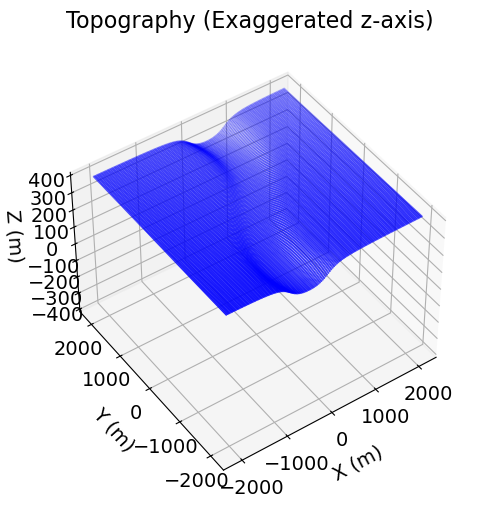

In [2]:
# Generate some topography
x_topo, y_topo = np.meshgrid(
    np.linspace(-2100, 2100, 141), np.linspace(-2100, 2100, 141)
)
z_topo = 410.0 + 140.0 * (1 / np.pi) * (
    np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) - 400.0) / 200.0)
    - np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) + 400.0) / 200.0)
)

# Turn into a (N, 3) numpy.ndarray
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)]

# Plot the topography
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([-400, 400])
ax.scatter3D(topo_xyz[:, 0], topo_xyz[:, 1], topo_xyz[:, 2], s=0.25, c="b")
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=45.0, azim=-125)

In [3]:
# Define the parameters for each survey line
survey_type = "dipole-dipole"
data_type = "volt"
dimension_type = "3D"
end_locations_list = [
    np.r_[-1000.0, 1000.0, 0.0, 0.0],
    np.r_[-1000.0, 1000.0, -1000.0, -1000.0],
    np.r_[-1000.0, 1000.0, -500.0, -500.0],
    np.r_[-1000.0, 1000.0, 500.0, 500.0],
    np.r_[-1000.0, 1000.0, 1000.0, 1000.0],
    np.r_[-600.0, -600.0, -1000.0, 1000.0],
    np.r_[-300.0, -300.0, -1000.0, 1000.0],
    np.r_[0.0, 0.0, -1000.0, 1000.0],
    np.r_[300.0, 300.0, -1000.0, 1000.0],
    np.r_[600.0, 600.0, -1000.0, 1000.0],
]  # [x0, x1, y0, y1]
station_separation = 100.0
num_rx_per_src = 8

# The source lists for each line can be appended to create the source
# list for the whole survey.
source_list = []
for ii in range(0, len(end_locations_list)):
    source_list += generate_dcip_sources_line(
        survey_type,
        data_type,
        dimension_type,
        end_locations_list[ii],
        topo_xyz,
        num_rx_per_src,
        station_separation,
    )

# Define the survey
survey = dc.survey.Survey(source_list)

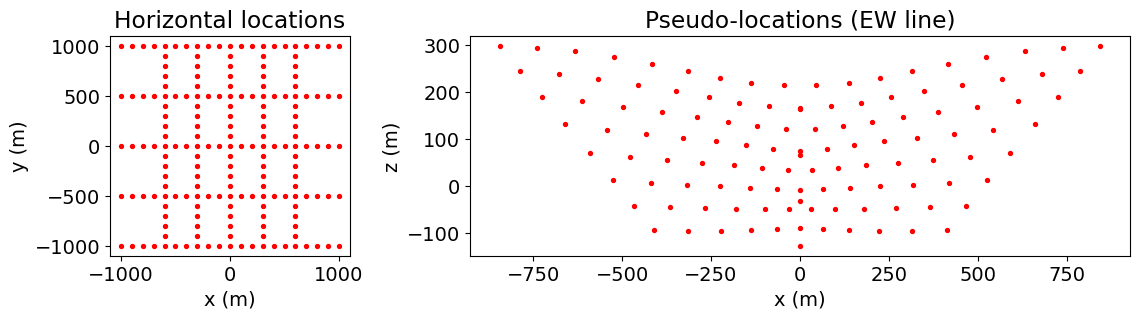

In [4]:
unique_locations = survey.unique_electrode_locations
fig = plt.figure(figsize=(12, 2.75))
ax1 = fig.add_axes([0.1, 0.1, 0.2, 0.8])
ax1.scatter(unique_locations[:, 0], unique_locations[:, 1], 8, "r")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
ax1.set_title("Horizontal locations")

pseudo_locations_xyz = pseudo_locations(survey)
inds = pseudo_locations_xyz[:, 1] == 0.0
ax2 = fig.add_axes([0.4, 0.1, 0.55, 0.8])
ax2.scatter(pseudo_locations_xyz[inds, 0], pseudo_locations_xyz[inds, -1], 8, "r")
ax2.set_xlabel("x (m)")
ax2.set_ylabel("z (m)")
ax2.set_title("Pseudo-locations (EW line)")
plt.show()

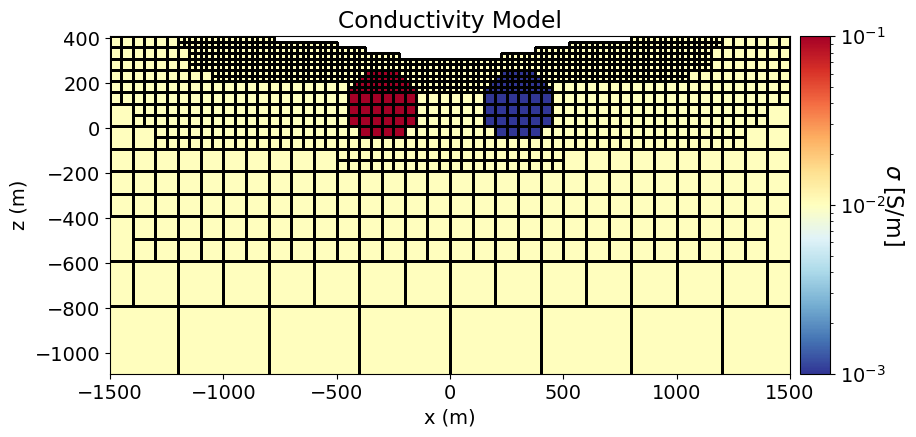

In [5]:
# Defining domain size and minimum cell size
dh = 25.0  # base cell width
dom_width_x = 8000.0  # domain width x
dom_width_y = 8000.0  # domain width y
dom_width_z = 4000.0  # domain width z

# Number of base mesh cells in each direction. Must be a power of 2
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, 0.0, z_topo.max()]

# Mesh refinement based on surface topography
k = np.sqrt(np.sum(topo_xyz[:, 0:2] ** 2, axis=1)) < 1200
mesh.refine_surface(topo_xyz[k, :], padding_cells_by_level=[0, 4, 4], finalize=False)

# Mesh refinement near electrodes.
mesh.refine_points(unique_locations, padding_cells_by_level=[6, 6, 4], finalize=False)

# Finalize the mesh
mesh.finalize()

# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_xyz)

# number of active cells
n_active = np.sum(active_cells)

# Define conductivity values in S/m (take reciprocal for resistivities in Ohm m)
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

# Define conductivity model
conductivity_model = background_conductivity * np.ones(n_active)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-300.0, 0.0, 100.0], 165.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[300.0, 0.0, 100.0], 165.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_resistor] = resistor_conductivity

# Define log-resistivity model
log_resistivity_model = np.log(1 / conductivity_model)

# Conductivity map. Model parameters are conductivities for all active cells.
conductivity_map = maps.InjectActiveCells(mesh, active_cells, air_conductivity)

# Resistivity map. Model parameters are log-resistivities for all active cells.
log_resistivity_map = maps.InjectActiveCells(
    mesh, active_cells, 1 / air_conductivity
) * maps.ExpMap(nP=n_active)

# Generate a mapping to ignore inactice cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

fig = plt.figure(figsize=(10, 4.5))

norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.15, 0.15, 0.68, 0.75])
mesh.plot_slice(
    plotting_map * conductivity_model,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_xlim([-1500, 1500])
ax1.set_ylim([z_topo.max() - 1500, z_topo.max()])

ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
cbar = mpl.colorbar.ColorbarBase(
    ax2, cmap=mpl.cm.RdYlBu_r, norm=norm, orientation="vertical"
)
cbar.set_label("$\sigma$ [S/m]", rotation=270, labelpad=15, size=16)

In [6]:
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

# DC simulation for a conductivity model
simulation_con = dc.simulation.Simulation3DNodal(
    mesh, survey=survey, sigmaMap=conductivity_map
)

# DC simulation for a log-resistivity model
simulation_res = dc.simulation.Simulation3DNodal(
    mesh, survey=survey, rhoMap=log_resistivity_map
)

In [7]:
dpred_con = simulation_con.dpred(conductivity_model)

In [8]:
apparent_conductivity = apparent_resistivity_from_voltage(survey, dpred_con) ** -1

# # Empty list for plane points
# plane_points = []

# # 3-points defining the plane for EW survey line
# p1, p2, p3 = np.array([-1000, 0, 0]), np.array([1000, 0, 0]), np.array([0, 0, -1000])
# plane_points.append([p1, p2, p3])

# # NS at x = -300 m
# p1, p2, p3 = (
#     np.array([-300, -1000, 0]),
#     np.array([-300, 1000, 0]),
#     np.array([-300, 0, -1000]),
# )
# plane_points.append([p1, p2, p3])

# # NS at x = 300 m
# p1, p2, p3 = (
#     np.array([300, -1000, 0]),
#     np.array([300, 1000, 0]),
#     np.array([300, 0, -1000]),
# )
# plane_points.append([p1, p2, p3])

# if has_plotly:
#     fig = plot_3d_pseudosection(
#         survey,
#         apparent_conductivity,
#         scale="log",
#         units="S/m",
#         plane_points=plane_points,
#         plane_distance=15,
#         marker_opts={"colorscale": "RdYlBu_r"},
#     )

#     fig.update_layout(
#         title_text="Apparent Conductivity",
#         title_x=0.5,
#         title_font_size=24,
#         width=650,
#         height=500,
#         scene_camera=dict(center=dict(x=0.05, y=0, z=-0.4)),
#     )

#     #     plotly.io.show(fig)
#     html_str = plotly.io.to_html(fig)
#     display(HTML(html_str))

# else:
#     print("INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS")

In [9]:
apparent_conductivity.shape
locs = torch.tensor(pseudo_locations(survey))

NameError: name 'torch' is not defined

In [48]:
locs[0, :]

tensor([-825.1931,  -12.5000,  296.4264], dtype=torch.float64)

In [131]:
# import torch

locs = torch.tensor(pseudo_locations(survey))
apparent_conductivity = torch.tensor(apparent_conductivity)

points = torch.tensor(mesh.cell_centers[active_cells, :])

# covs = torch.zeros(locs.shape[0], 3, 3)
covariance_matrix = torch.eye(3) * 100 ** 2
# covariance_matrix-1, 1] = 0.1 ** 2

gaussians = [None] * locs.shape[0]
fp = [None] * locs.shape[0]

for ii in range(0, locs.shape[0]):
    mean = locs[ii, :]
    gaussians[ii] = torch.distributions.MultivariateNormal(mean, covariance_matrix)

model_res = torch.zeros(points.shape[0])

for kk in range(model_res.shape[0]):
    for jj in range(len(gaussians)):
        fp[jj] = apparent_conductivity[jj] * torch.exp(gaussians[jj].log_prob(points[kk, :]))

    model_res[kk] = torch.sum((1 / apparent_conductivity) * torch.tensor(fp/np.max(fp)))
# Create a multivariate normal distribution
# gaussian = torch.distributions.MultivariateNormal(mean, covariance_matrix)

# # Compute sigmoid
# sigmoid = torch.sigmoid(torch.tensor([0.5]))

# np.random.seed(0)
# num_points = 1000
# points = np.random.rand(num_points, 3) * 100  # Random points in a 100x100x100 space
# intensities = np.ones(num_points) * 200 # np.random.rand(num_points)  # Random intensities for the points

# # Define voxel volume shape
# volume_shape = (len(mesh.h[0]), len(mesh.h[1]), len(mesh.h[2]))

# depth, width, height = volume_shape
# volume = np.zeros(volume_shape)

# ii=0

# diff = torch.tensor(mesh.cell_centers[0, :]) - locs[ii, :]
# diff.type(torch.float64)
# torch.exp(-0.5 * (diff @ covs[ii, :, :].inverse().type(torch.float64) @ diff.T))
# # g1 = sigmoid * 

/tmp/ipykernel_24417/2355427489.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_24417/2355427489.py:25: RuntimeWarning:

invalid value encountered in divide



In [132]:
# np.save("apparent_resistivity.npy", model_res.detach().numpy())
# plt.plot(fp/np.max(fp), 'o')
# print(torch.tensor(fp).mean())
# torch.sigmoid(torch.tensor(fp))
# 1 / apparent_conductivity.max()

tensor(301.8597, dtype=torch.float64)


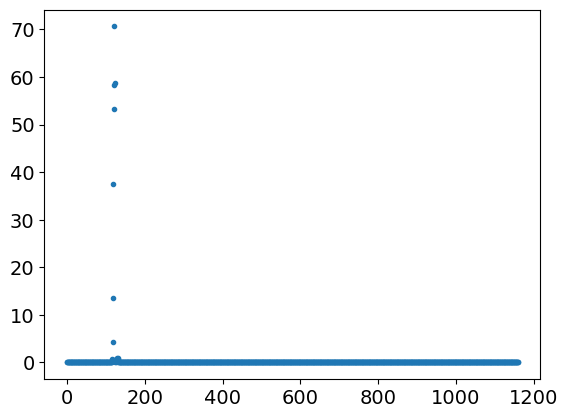

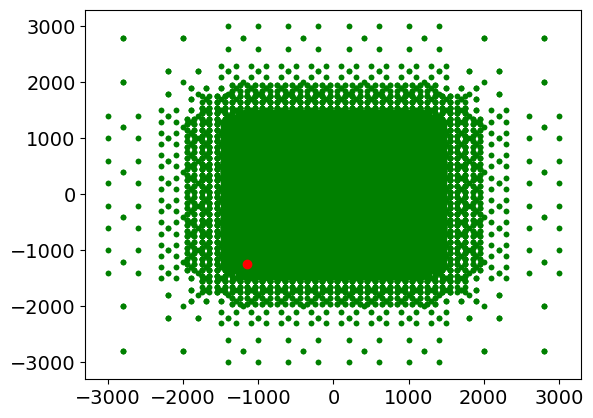

In [130]:
plt.plot((1 / apparent_conductivity) * torch.tensor(fp/np.max(fp)), '.')
print(torch.sum((1 / apparent_conductivity) * torch.tensor(fp/np.max(fp))))
plt.show()
plt.plot(points[:, 0], points[:, 1], '.g')
plt.plot(points[1000, 0], points[1000, 1], 'or')

# covs[0, -1, 1] = 0.1 ** 2
print(torch.exp(-0.5 * (diff @ covs[ii, :, :].inverse().type(torch.float64) @ diff.T)))


In [120]:
import torch
import torch
import plotly.graph_objects as go

# Define the mean and covariance matrix
mean = torch.zeros(3)
covariance_matrix = torch.eye(3) * 10 ** 2
covariance_matrix[2,2] = 20 ** 2

# Create a multivariate normal distribution
gaussian = torch.distributions.MultivariateNormal(mean, covariance_matrix)

# Generate samples from the distribution
samples = points (gaussian.sample((1000,)))

# Access the x, y, and z coordinates of the samples
x = samples[:, 0]
y = samples[:, 1]
z = samples[:, 2]

# Create a 3D scatter plot
c = 'red'
fig = go.Figure(data=go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(color=c)))

# Set plot layout
fig.update_layout(
    title='3D Gaussian Distribution',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

# Show the plot
fig.show()


In [47]:
np.exp(gaussian.log_prob(torch.tensor([0.8, 0.1, 0.4])))

tensor(3.3002e-14)

In [134]:
import plotly.graph_objects as go

# Generate some sample data
samples = points

# Access the x, y, and z coordinates of the samples
x = samples[:, 0]
y = samples[:, 1]
z = samples[:, 2]
values = model_res

# Create a 3D scatter plot
fig = go.Figure(data=go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=10,
        color=values,  # Color the points based on the values
        colorscale='RdBu',  # Choose a colorscale
        opacity=0.8
    )
))

# Set plot layout
fig.update_layout(
    title='3D Scatter Plot with Colored Points',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

# Show the plot
fig.show()



In [137]:
model_res[100]

tensor(113.4754)

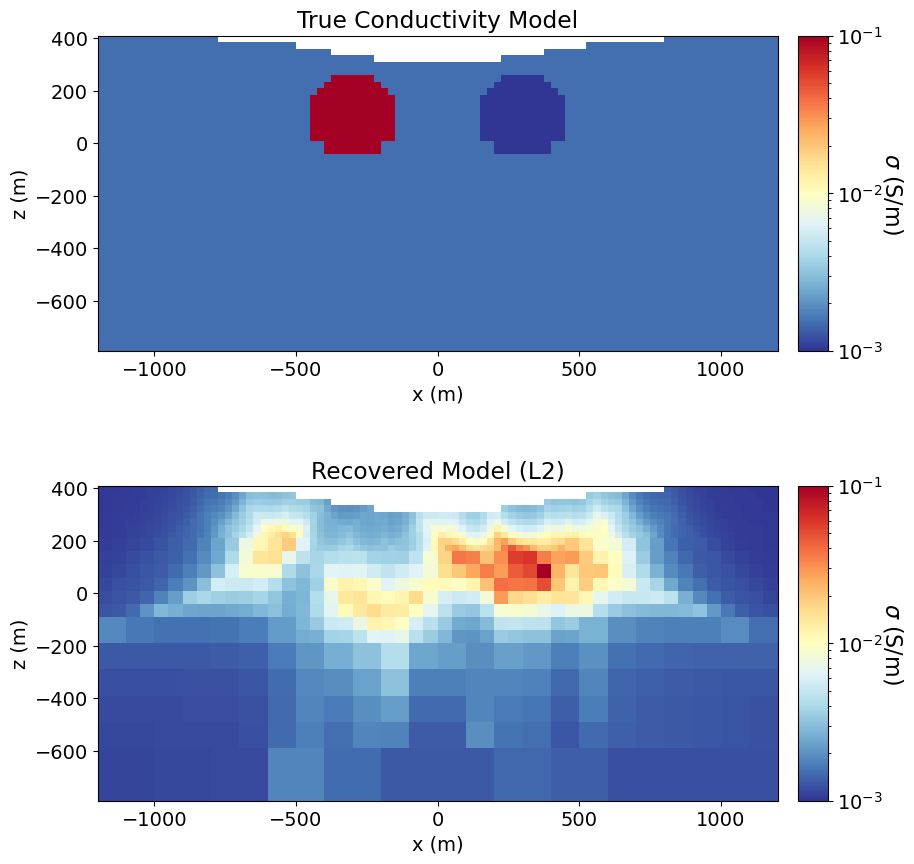

In [146]:
norm = LogNorm(vmin=1e-3, vmax=1e-1)

fig = plt.figure(figsize=(10, 9))
ax1 = 2 * [None]
ax2 = 2 * [None]
cbar = 2 * [None]
title_str = [
    "True Conductivity Model",
    "Recovered Model (L2)",
]
plotting_model = [
    conductivity_model,
    model_res.detach().numpy(),
]

for ii in range(0, 2):
    ax1[ii] = fig.add_axes([0.14, 0.6 - 0.5 * ii, 0.68, 0.35])

    temp = plotting_map * plotting_model[ii]

    mesh.plot_slice(
        temp,
        ax=ax1[ii],
        normal="Y",
        ind=int(len(mesh.h[1]) / 2),
        grid=False,
        pcolor_opts={"cmap": mpl.cm.RdYlBu_r},
    )
    ax1[ii].set_title(title_str[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("z (m)")
    ax1[ii].set_xlim([-1200, 1200])
    ax1[ii].set_ylim([topo_xyz[:, -1].max() - 1200, topo_xyz[:, -1].max()])

    ax2[ii] = fig.add_axes([0.84, 0.6 - 0.5 * ii, 0.03, 0.35])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
    )
    cbar[ii].set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=16)

In [156]:
dpredd = simulation_con.dpred(1 / np.nan_to_num(model_res.detach().numpy(), nan=300.0))

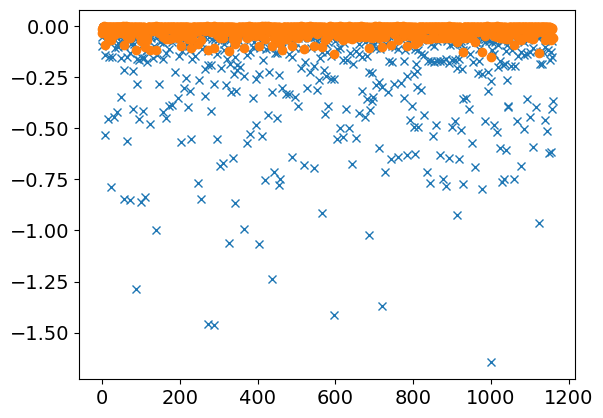

In [158]:
# np.isnan(model_res.detach().numpy()).sum()
plt.plot(dpredd, 'x')
plt.plot(dpred_con, 'o')

In [159]:
import torch
import torch.optim as optim
import numpy as np

# Define the negative log likelihood function for multivariate Gaussian
def negative_log_likelihood(data, mean, covariance):
    n = data.size(0)
    k = data.size(1)
    constant_term = 0.5 * k * torch.log(2 * torch.tensor(np.pi))
    log_det_covariance = torch.logdet(covariance)
    inverse_covariance = torch.inverse(covariance)
    quadratic_term = 0.5 * torch.trace(torch.mm(torch.mm((data - mean).t(), inverse_covariance), data - mean))
    return constant_term + 0.5 * log_det_covariance + quadratic_term

# Generate some random data
torch.manual_seed(42)
data = torch.randn(100, 2)

# Initialize mean and covariance matrix
mean = torch.mean(data, dim=0)
covariance = torch.tensor([[1., 0.], [0., 1.]], requires_grad=True)

# Define optimizer
optimizer = optim.Adam([covariance], lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = negative_log_likelihood(data, mean, covariance)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

print("Estimated Covariance Matrix:")
print(covariance.detach().numpy())



RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x100 and 2x2)